In [33]:
!pip install yfinance
!pip install GaussianHMM
!pip install hmmlearn
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement GaussianHMM (from versions: none)
ERROR: No matching distribution found for GaussianHMM


In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

plt.style.use("seaborn-v0_8")


In [35]:
# getting data from yahoo finance (yfinance) fo apple
ticker = "AML.L"
data = yf.download(ticker, start="2014-01-01")
data.head(), data.columns

/tmp/ipython-input-743876058.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2014-01-01")
[*********************100%***********************]  1 of 1 completed


(Price             Close         High          Low         Open    Volume
 Ticker            AML.L        AML.L        AML.L        AML.L     AML.L
 Date                                                                    
 2018-10-03  4307.657715  4557.549316  4151.058594  4521.850586  10068884
 2018-10-04  4283.858398  4366.679688  4175.333984  4309.085449   1547968
 2018-10-05  4045.866211  4271.958984  4045.866211  4271.958984   1332784
 2018-10-08  3807.874023  4067.285400  3722.672852  4067.285400    822247
 2018-10-09  3793.594482  3926.870117  3785.026855  3807.398193    746738,
 MultiIndex([( 'Close', 'AML.L'),
             (  'High', 'AML.L'),
             (   'Low', 'AML.L'),
             (  'Open', 'AML.L'),
             ('Volume', 'AML.L')],
            names=['Price', 'Ticker']))

In [36]:
#getting columns and size of
print("coloumn- ",data.columns)
print("size -  ",data.size)

coloumn-  MultiIndex([( 'Close', 'AML.L'),
            (  'High', 'AML.L'),
            (   'Low', 'AML.L'),
            (  'Open', 'AML.L'),
            ('Volume', 'AML.L')],
           names=['Price', 'Ticker'])
size -   9020


In [37]:
close_price = data[('Close', ticker)].copy()
df = close_price.to_frame(name='Close')
df['Return'] = df['Close'].pct_change()
df = df.dropna()

returns = df['Return'].values.reshape(-1, 1)
dates = df.index
df.head()

,Close,Return
Date,,
2018-10-04,4283.858398,-0.005525
2018-10-05,4045.866211,-0.055556
2018-10-08,3807.874023,-0.058824
2018-10-09,3793.594482,-0.003750
2018-10-10,3831.673340,0.010038


In [38]:
from hmmlearn.hmm import GaussianHMM

model = GaussianHMM(n_components=3, covariance_type="full", n_iter=300)
model.fit(returns)
hidden_states = model.predict(returns)
hidden_states

array([1, 2, 2, ..., 1, 1, 1])

In [39]:
means = model.means_.flatten()
variances = np.array([np.diag(cov)[0] for cov in model.covars_])

for i in range(model.n_components):
    print(f"STATE {i}: Mean = {means[i]:.6f}, Variance = {variances[i]:.6f}")
print("Positive 'Mean' represent bullish trend (upward trend)")
print("Negative 'Mean' represent bearish trend (downwards trend)")

STATE 0: Mean = -0.001368, Variance = 0.016371
STATE 1: Mean = -0.001340, Variance = 0.000513
STATE 2: Mean = -0.000934, Variance = 0.002236
Positive 'Mean' represent bullish trend (upward trend)
Negative 'Mean' represent bearish trend (downwards trend)


In [40]:
regimes = df.copy()
regimes['State'] = hidden_states
regimes.head()

,Close,Return,State
Date,,,
2018-10-04,4283.858398,-0.005525,1
2018-10-05,4045.866211,-0.055556,2
2018-10-08,3807.874023,-0.058824,2
2018-10-09,3793.594482,-0.003750,2
2018-10-10,3831.673340,0.010038,2


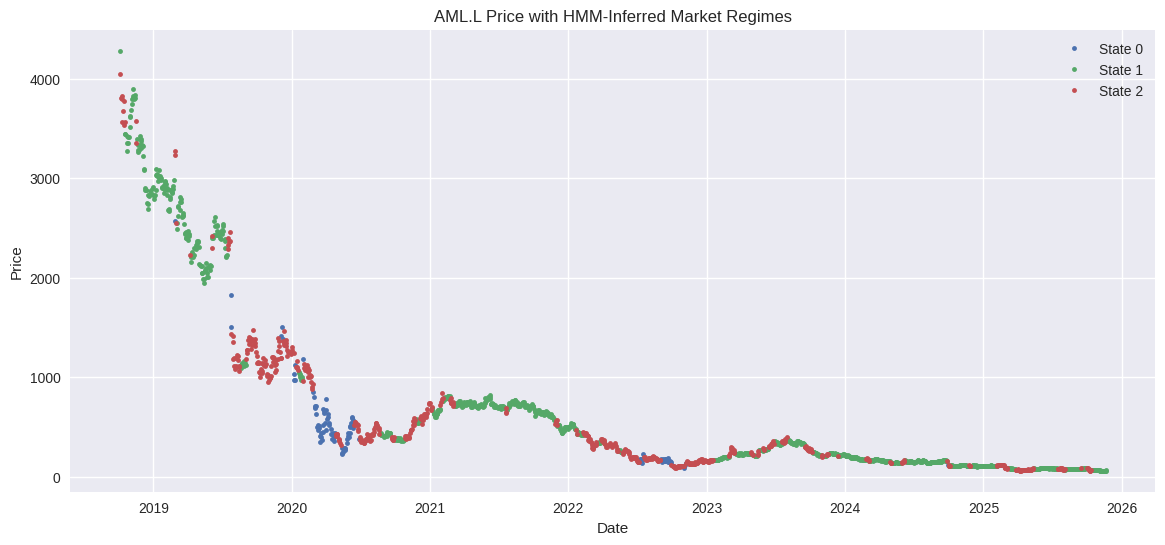

In [41]:
plt.figure(figsize=(14,6))

for s in range(model.n_components):
    subset = regimes[regimes['State'] == s]
    plt.plot(subset.index, subset['Close'], '.', label=f"State {s}")

plt.title(f"{ticker} Price with HMM-Inferred Market Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

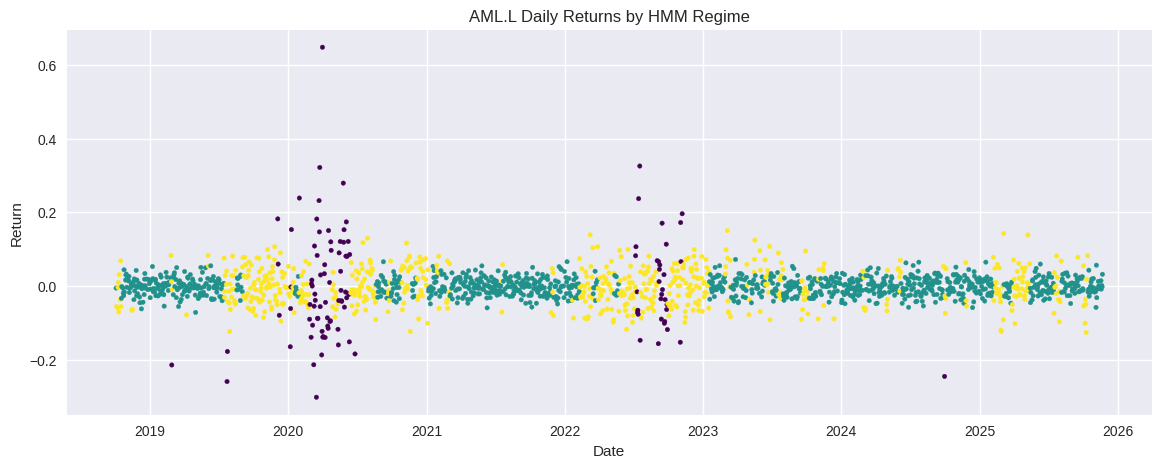

In [42]:
plt.figure(figsize=(14,5))
plt.scatter(regimes.index, regimes['Return'], c=regimes['State'], cmap='viridis', s=10)
plt.title(f"{ticker} Daily Returns by HMM Regime")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

In [43]:
print("Transition Matrix:")
print(model.transmat_)

Transition Matrix:
[[8.59915124e-01 3.82817283e-06 1.40081048e-01]
 [8.22884278e-08 8.73896322e-01 1.26103596e-01]
 [2.80308500e-02 1.71922225e-01 8.00046925e-01]]


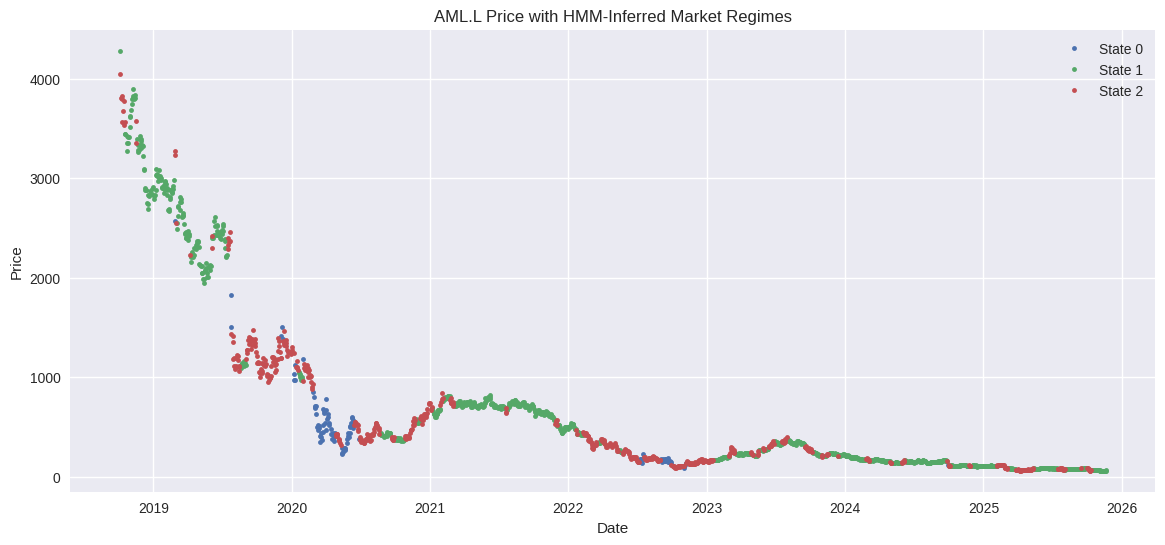

In [44]:
plt.figure(figsize=(14,6))

for s in range(model.n_components):
    subset = regimes[regimes['State'] == s]
    plt.plot(subset.index, subset['Close'], '.', label=f"State {s}")

plt.title(f"{ticker} Price with HMM-Inferred Market Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [45]:
for s in range(model.n_components):
    stay_prob = model.transmat_[s, s]
    duration = 1 / (1 - stay_prob)
    print(f"Expected Duration in State {s}: {duration:.2f} days")


Expected Duration in State 0: 7.14 days
Expected Duration in State 1: 7.93 days
Expected Duration in State 2: 5.00 days


In [46]:
curr = hidden_states[-1]
print("Current State:", curr)
print("Next-day probabilities:", model.transmat_[curr])


Current State: 1
Next-day probabilities: [8.22884278e-08 8.73896322e-01 1.26103596e-01]


In [47]:
dist = np.zeros(model.n_components)
dist[curr] = 1.0

for i in range(10):
    dist = dist @ model.transmat_
    print(f"Day {i+1} distribution: {dist}")


Day 1 distribution: [8.22884278e-08 8.73896322e-01 1.26103596e-01]
Day 2 distribution: [0.00353493 0.78537479 0.21109027]
Day 3 distribution: [0.00895685 0.72262727 0.26841589]
Day 4 distribution: [0.01522611 0.677648   0.30712589]
Day 5 distribution: [0.02170222 0.64499592 0.33330186]
Day 6 distribution: [0.02800486 0.62096164 0.3510335 ]
Day 7 distribution: [0.03392162 0.60300666 0.36307172]
Day 8 distribution: [0.03934697 0.58938553 0.3712675 ]
Day 9 distribution: [0.04424205 0.57889113 0.37686682]
Day 10 distribution: [0.04860835 0.57068278 0.38070887]
